# Hospital Assignment Problem

Upon graduating from medical school, aspiring doctors in the United States are required to complete a medical residency --- a stay of at least 3 years (longer for certain specialties) at a single hospital where they will practice medicine on a restricted license under the guidance of more experienced, fully-licensed physicians. This means that medical students in their final year of study must begin thinking about which hospital(s) would be their ideal choice for serving out a residency.

With certain hospitals and geographical locations being more prestigious or desirable than others, it is generally impossible to assign all graduates to their first choice of hospital. In recent years, there has also been a mismatch between the number of graduates and the number of open residency positions; in 2023, there were almost 43,000 graduates vying for just 40,375 residency slots. In order to facilitate an assignment process that's as fair and effective as possible, prospective residents are asked to fill out a preference list in which they rank their top hospital choices. These preference lists are then aggregated and used to create the ``best" possible assignment of new residents to hospitals.

Consider a small example with 4 graduates applying for residencies at 3 different hospitals. Each graduate ranks their first choice of hospital as 1, their second choice as 2, and their third choice as 3. An aggregated preference list might look like
\begin{equation*}
\begin{matrix}
\text{graduate 1}\quad \\
\text{graduate 2}\quad \\
\text{graduate 3}\quad \\
\text{graduate 4}\quad
\end{matrix}
\left[
\begin{matrix}
2 & 1 & 3 \\
1 & 2 & 3 \\
1 & 2 & 3 \\
2 & 3 & 1
\end{matrix}
\right]
\end{equation*}
with each column corresponding to a hospital.  Here, graduate 1's first choice is hospital 2, their second choice is hospital 1, and their third choice is hospital 3. Our goal is to come up with the "best" assignment possible, but what constitutes "best" is not always clear. Should we maximize the number of people who get their first choice? Minimize the number that get their third choice? Or find some balance between the two? We can get different solutions that favor one approach over others by varying how we use these preferences in our the objective function. 

One option would be simply using the preferences directly as costs; e.g., assigning graduate 1 to hospital 2 incurs a cost of 1, while assigning them to hospital 3 has a cost of 3. We could steepen the penalties for assigning a second or third choice by raising all preferences to some power $p>1$; e.g., setting $p=2$ (squaring all preferences) would mean graduate 1 $\rightarrow$ hospital 2 still has cost 1 but graduate 1 $\rightarrow$ hospital 3 now costs 9.  We could also dilute penalties for assigning second or third choices by raising all preferences to a power $0<p<1$.

For this problem, you will start from \textbf{code provided for you on Canvas} in a notebook titled \textcolor{blue}{hospitalassignment.ipynb} in the Homework Documents folder of Files. The first code block of the notebook generates data for a hospital assignment problem with 100 graduates and 5 hospitals and doesn't need to be modified. 

In the second block of code, you will formulate this assignment problem as a balanced transportation problem, with each graduate assigned to one hospital and 20 graduates assigned to each hospital. It could also be formulated as a MCNFP, but constructing an incidence matrix could be a bit unwieldy given the problem's size. 

Start by defining variables and constraints above the already included ${\tt for}$ loop You will solve this problem 4 times, raising the preference list to the powers 0.25, 1, 2, and 4 in turn; a  is already set up in the second code block. In this second block, you should put the variables and constraints of your model prior to the loop. Inside the loop, you should create the objective function based on the power the preference list is raised to (using the ${\tt preferences}$ matrix that's already defined there). Then, update the line of code just below ${\tt optimize!(m)}$ with the name of your decision variables (which should be indexed over [graduates (1-100), hospitals (1-5)]).

If done properly, the rest of the code will compile the data from the solutions and the third code block will plot the 4 different solutions. 

After getting the code up and running and displaying the four solutions, **answer the following questions in Markdown below the final code cell**:

- Which of the four solutions do you consider to be ``best", and why?

- How would you modify the problem if there were more graduates than residency positions, as was the case in 2023?

The code directly below this should run as is (so long as you have the proper libraries; if not, make sure to add them as described in the first comment). This code will set up the matrix of preferences of the 100 people for each of the 5 hospitals and place it in the matrix preferencelist.

In [22]:
#If you have not installed Random before, call
#using Pkg
#Pkg.add("Random")
using Random

#Set the random seed so this always gives the same results.
#You may change this to different numbers to see the results, but please
#submit using seed 10
Random.seed!(10)

#Number of graduates
ng = 100
#Number of hospitals
nh = 5

#Create a preference list with ng rows and nh columns
#(each row is the preferences of 1 graduate)
preferencelist = zeros(ng, nh)
#Generate a random permutation of the numbers 1 through 5
pref = shuffle(1:nh)
#Copy this shuffle 60 times (to make the problem difficult to assign)
for i in 1:60
    preferencelist[i,:] = pref
end

#The last 40 preferences are all random permutations
for i in 61:ng
    preferencelist[i,:] = shuffle(1:nh)
end

#Print out the last 3 rows, to see what this list looks like.
#Each row is a graduate with 5 entries that rate each of the 5
#hospitals as 1 through 5.
for i in ng-2:ng
    println(preferencelist[i,:])
end
;

[2.0, 3.0, 4.0, 5.0, 1.0]
[5.0, 3.0, 4.0, 1.0, 2.0]
[1.0, 5.0, 4.0, 2.0, 3.0]


The data is set up, so it's time to move onto the model. We will solve this problem 4 times with the same set of variables and constraints but a new objective function each time. The code below has 3 spots where you need to insert or modify it with your model to make it work.

In [23]:
using JuMP, HiGHS

#Powers that we will raise the preference list to
powers = [1/4 1 2 4];

#Create the model
m = Model(HiGHS.Optimizer)
#set_silent suppresses the output during solving
#this is nice when we solve multiple times
set_silent(m)

#Define the variables and constraints in your model.
#Your decision variables should be a matrix indexed
#by [graduates,hospitals] (1 entry for each pair)


#INSERT YOUR CODE HERE
@variable(m, 0 <= x[1:ng, 1:nh])

@constraint(m, [i in 1:ng], sum(x[i,j] for j in 1:nh) == 1)
@constraint(m, [j in 1:nh], sum(x[i,j] for i in 1:ng) <= 20)

#Dictionary that will store the solution. It will map the numbers
#1 through 4 to the 4 different solutions (in terms of the decision
#variables, which should be a matrix).
solution = Dict()

#Keep track of the iteration number (for saving solutions)
iteration = 1
#Loop through all elements in power. Solve a new model each
#time.
for p in powers
    #Raise the preferences list to the power p (elementwise)
    #Use this matrix to define the objective function each time through the loop
    preferences = preferencelist.^p

    #Insert your objective function HERE
    @objective(m, Min, sum(sum(preferences[i,j]*x[i,j] for i in 1:ng) for j in 1:nh))

    optimize!(m)

    #UPDATE THE CODE BELOW
    #Uncomment this code and insert the name of your
    #decision variable instead of ``mydecisionvariable"

    solution[iteration] = value.(x)

    iteration = iteration + 1
end

#If everything was done properly above, the rest of the code should run
#without needing changes

#Set up a matrix with nh rows and 4 columns
#Each column is the solution for a different power,
#where the number of people who were assigned their first choice
#are in row 1, the number of people who were assigned their
#second choice are in row 2, etc.
preferencecount = zeros(nh,length(powers))
for k in 1:length(powers)
    #Look at the k-th solution, should be a matrixed
    #indexed over [people,hospitals]
    soln = solution[k]

    #Loop through the soln matrix
    for i in 1:ng
        for j in 1:nh
            #If the current element we are looking at has an entry of 1
            #(so it was chosen as part of the assignment)
            if(soln[i,j] > 0.5)
                #Determine what preference this person had for this assignment
                #(should be a number 1-5).
                pref = convert(Int64,preferencelist[i,j])
                #Increase the entry in preferencecount for that preference
                #(For example, if this assignment had a preference of 3 and we have seen
                #one 3 previously, this updates the count to two 3's having been seen)
                preferencecount[pref,k] = preferencecount[pref,k] + 1
            end
        end
    end
end

#Show the preference count as a matrix. First row is number
#of graduates assigned their first preference for the 4 different trials,
#the second row is the number of graduates assigned their second preference...
for i in 1:nh
    println(preferencecount[i,:])
end

[49.0, 45.0, 41.0, 35.0]
[25.0, 29.0, 34.0, 36.0]
[10.0, 14.0, 16.0, 24.0]
[13.0, 12.0, 9.0, 5.0]
[3.0, 0.0, 0.0, 0.0]


Now let's plot the different solutions.

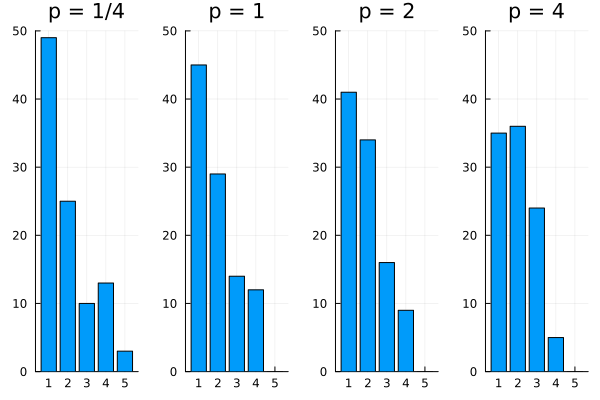

In [24]:
#If you have not installed plots before, run
#using Pkg
#Pkg.add("Plots")
using Plots

#Generate bar plots of each solution. Notice how the solution changes
#as we raise the preferences to a higher power
plot1 = bar(1:5, preferencecount[:,1], title = "p = 1/4", ylims = (0,50))
plot2 = bar(1:5, preferencecount[:,2], title = "p = 1", ylims = (0,50))
plot3 = bar(1:5, preferencecount[:,3], title = "p = 2", ylims = (0,50))
plot4 = bar(1:5, preferencecount[:,4], title = "p = 4", ylims = (0,50))
plot(plot1, plot2, plot3, plot4, layout = (1, 4), legend = false)

- Which of the four solutions do you consider to be ``best", and why?

- How would you modify the problem if there were more graduates than residency positions, as was the case in 2023?




I consider p=1/4 to be the best in my opinion, because it maximizes the number 1 matches. Over half the applicants get their options 1-3, while only a fraction receive 4-5. 

If there were more graduates than residency positions, I would create a dummy hospital with a demand set to make up the difference between hospitals and applying graduates. There would be no edges costs. The people assigned to the dummy hospital would be the ones who are not able to be matched up with a hospital. 